In [ ]:
from pipelines import unet_train
from pipeline_config import SOLUTION_CONFIG

pipe = unet_train(SOLUTION_CONFIG)
pipe

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
a,b = joblib.load('/mnt/ml-team/dsb_2018/kuba/labeler_debug.pkl')

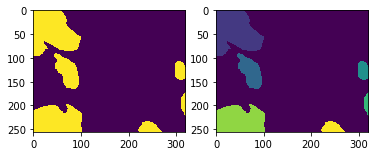

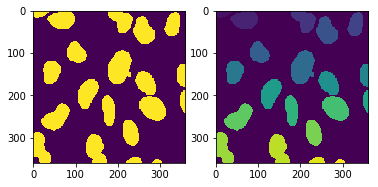

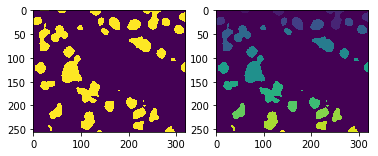

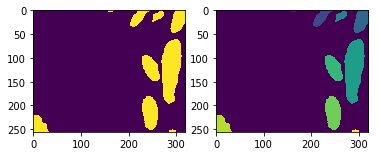

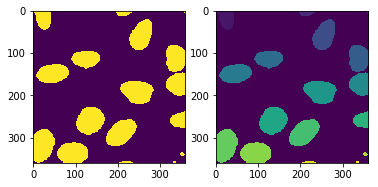

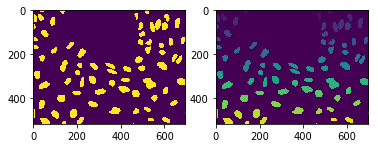

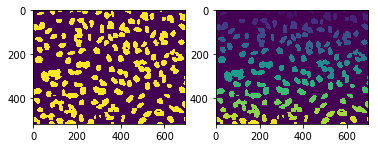

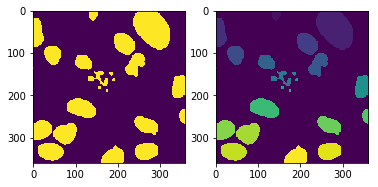

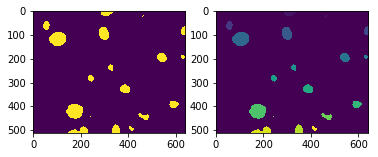

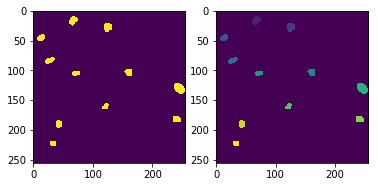

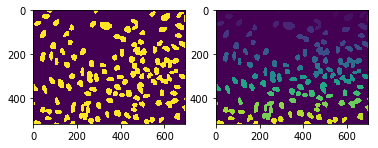

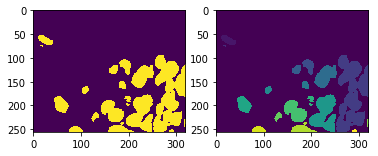

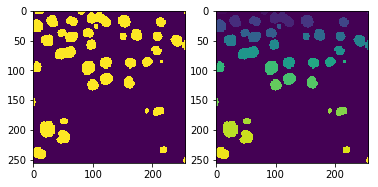

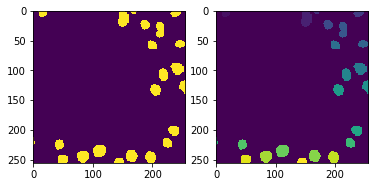

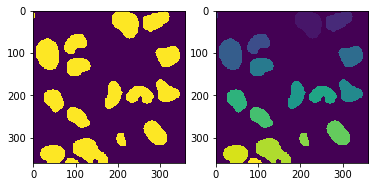

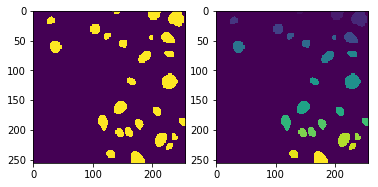

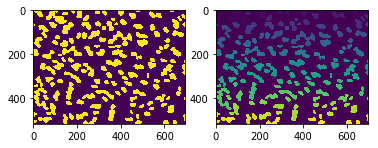

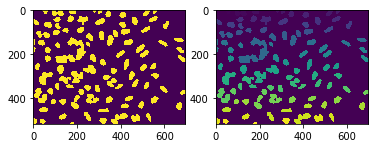

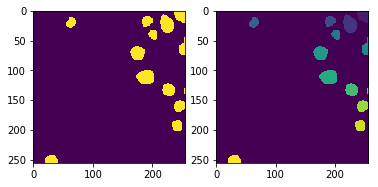

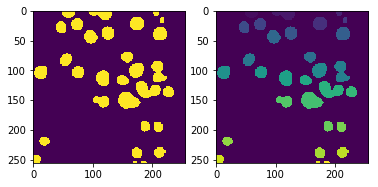

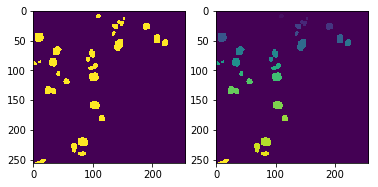

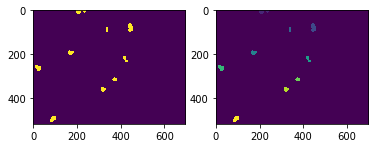

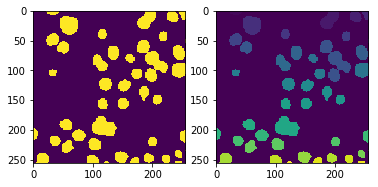

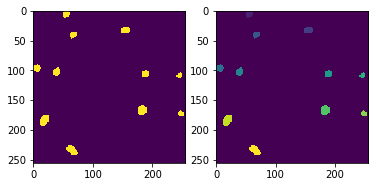

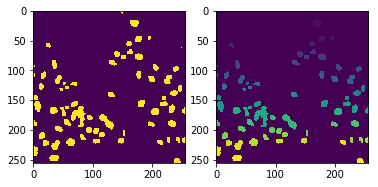

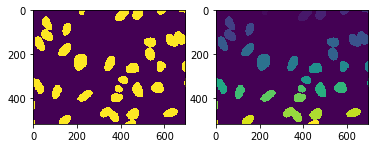

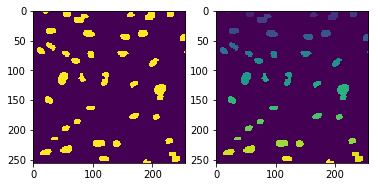

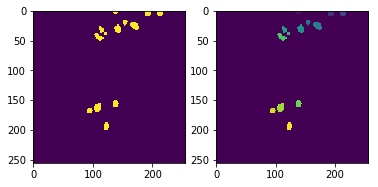

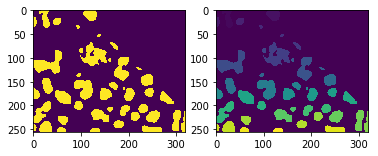

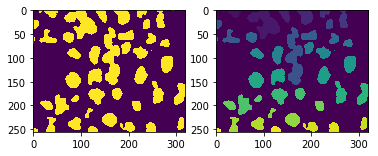

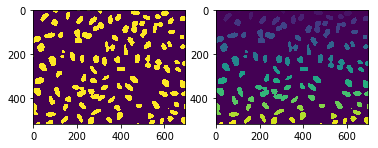

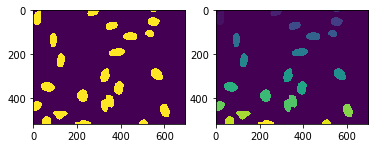

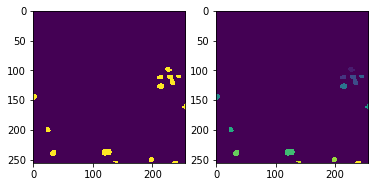

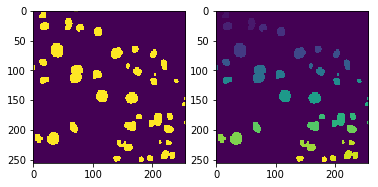

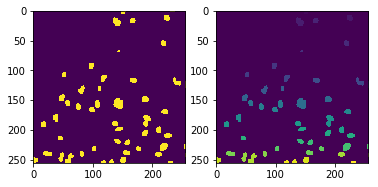

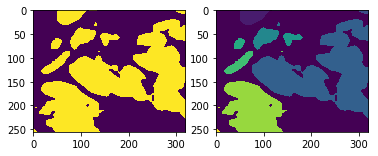

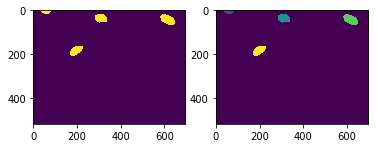

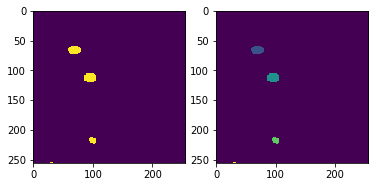

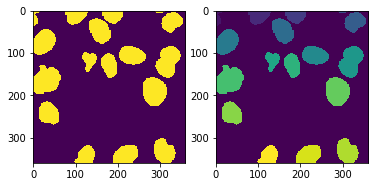

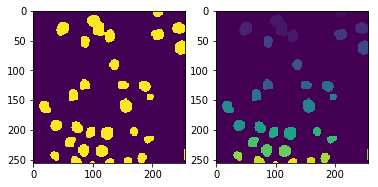

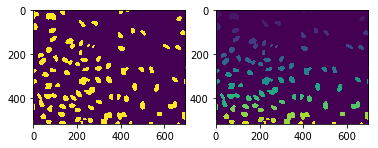

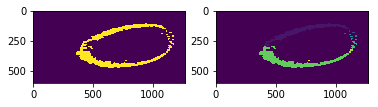

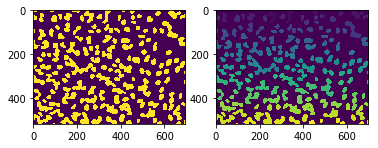

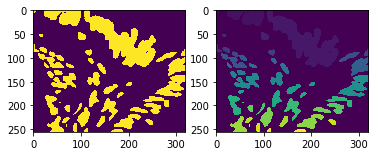

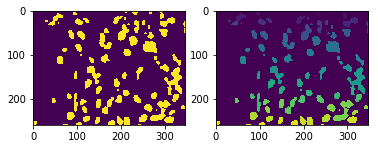

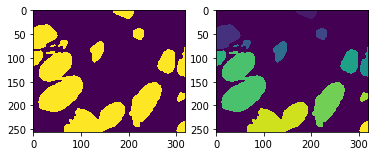

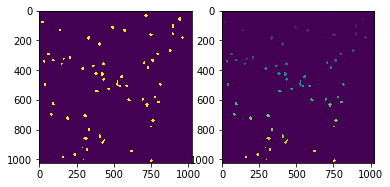

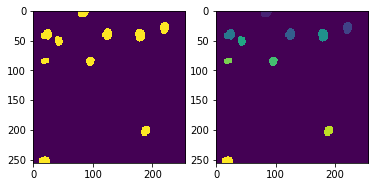

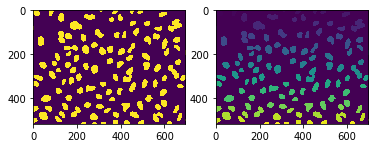

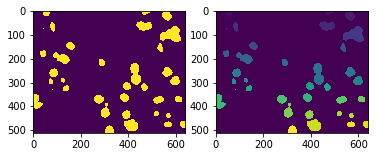

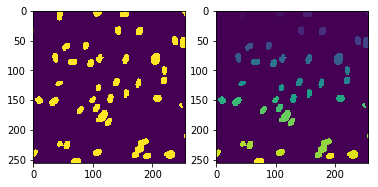

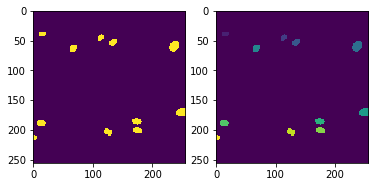

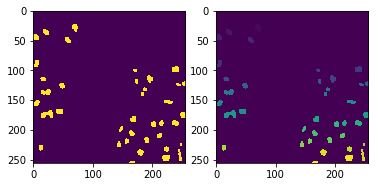

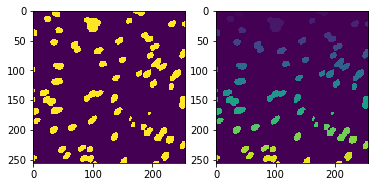

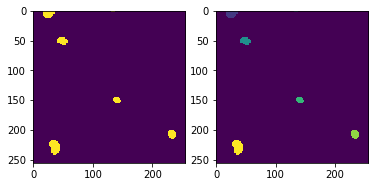

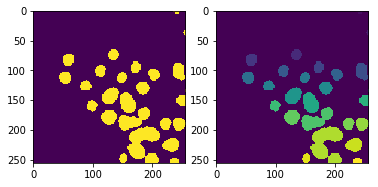

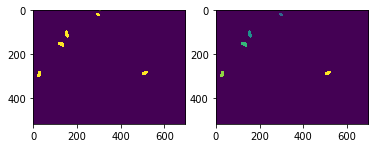

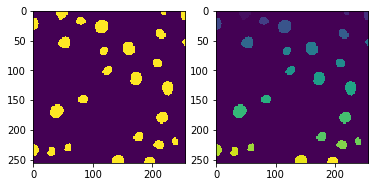

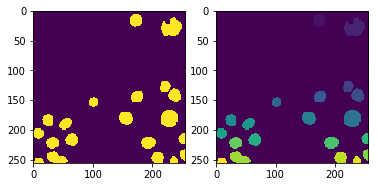

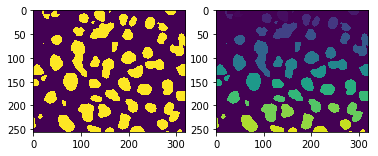

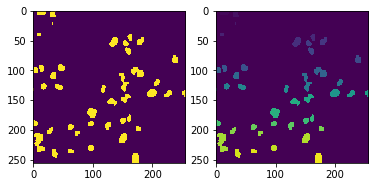

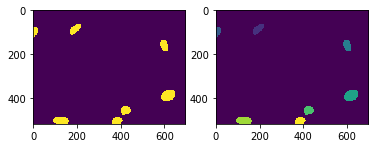

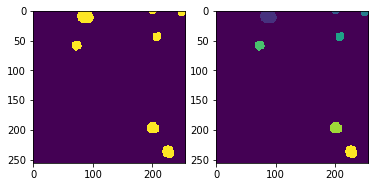

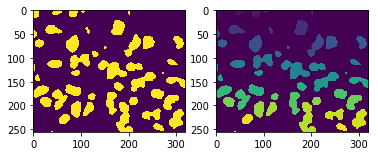

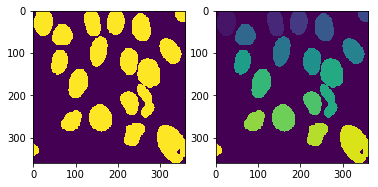

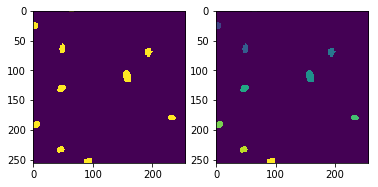

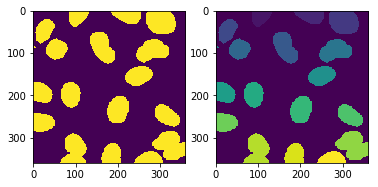

In [24]:
for im_a, im_b in zip(a,b):
    plt.subplot(121)
    plt.imshow(im_a)
    plt.subplot(122)
    plt.imshow(im_b)
    plt.show()